In [1]:
import json
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

In [2]:
with open("couples.json") as json_file:
    couples = json.load(json_file)

In [3]:
max_neig = 1
# Create a graph
G = nx.Graph()

# Add edges to the graph based on the dictionary
for node, neighbors in couples.items():
    count = 0
    for neighbor, weight in neighbors:
        if count < max_neig:
            G.add_edge(node, neighbor, weight=weight)
            count += 1

In [4]:
def get_edges_colors(G):
    # color edegs according to their connection, the greener the color the stringer the connection
    # Create a colormap ranging from red to green
    cmap = plt.cm.RdYlGn_r

    # Find the maximum and minimum weights
    max_weight = max([d['weight'] for _, _, d in G.edges(data=True)])
    min_weight = min([d['weight'] for _, _, d in G.edges(data=True)])

    # Normalize the weights
    norm = mcolors.Normalize(vmin=min_weight, vmax=max_weight)

    # Create a color mapping based on edge weights
    edge_colors = [cmap(norm(d['weight'])) for _, _, d in G.edges(data=True)]
    return edge_colors
    

### Visualize the whole graph

In [5]:
# edge_colors = get_edges_colors(G)
# plt.figure(figsize=(8, 8))
# pos = nx.spring_layout(G, k=0.3, iterations=20)
# nx.draw_networkx_nodes(G, pos, node_size=300, node_color='skyblue')
# nx.draw_networkx_edges(G, pos, edge_color=edge_colors, width=2)
# nx.draw_networkx_labels(G, pos, font_size=8)
# plt.title('Amino Acid Sequence Graph (Highest Degree Nodes and Their Connections)')
# plt.axis('off')  # Turn off axis
# plt.savefig('trunc seq whole graph.png')
# plt.show()

### Highest degree node

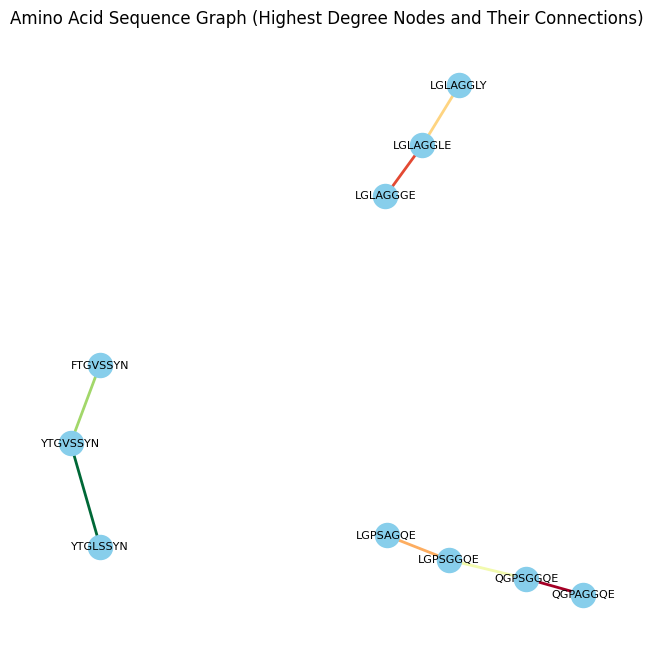

In [6]:
max_degree = max(dict(G.degree()).values())
highest_degree_nodes = [node for node, degree in dict(G.degree()).items() if degree == max_degree]

# Create a subgraph with only the highest degree nodes and their neighbors
highest_degree_neighbors = set()
for node in highest_degree_nodes:
    highest_degree_neighbors.update(G.neighbors(node))
highest_degree_neighbors.update(highest_degree_nodes)
H = G.subgraph(highest_degree_neighbors)

edge_colors = get_edges_colors(H)

# Visualize the graph
plt.figure(figsize=(8, 8))
pos = nx.spring_layout(H, k=0.3, iterations=20)
nx.draw_networkx_nodes(H, pos, node_size=300, node_color='skyblue')
nx.draw_networkx_edges(H, pos, edge_color=edge_colors, width=2)
nx.draw_networkx_labels(H, pos, font_size=8)
plt.title('Amino Acid Sequence Graph (Highest Degree Nodes and Their Connections)')
plt.axis('off')  # Turn off axis
plt.savefig('degree.png')
plt.show()


### Longest path

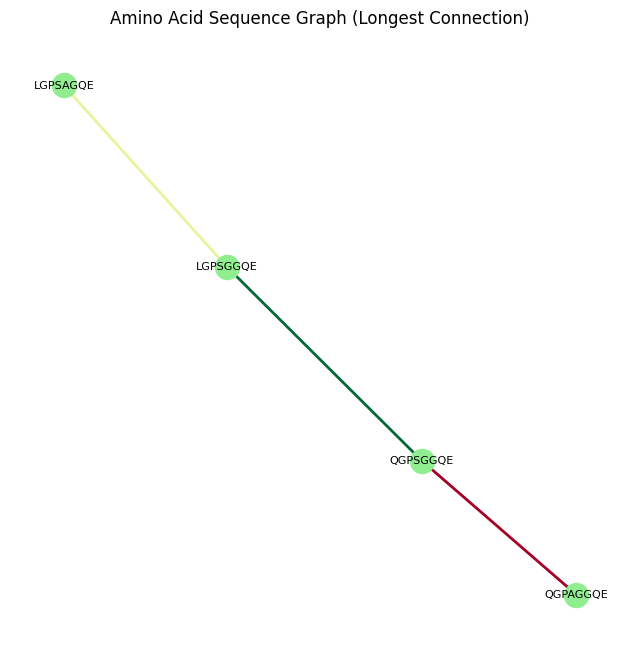

In [7]:
# Find the longest path in the graph
longest_path = max(nx.all_pairs_shortest_path_length(G), key=lambda x: max(x[1].values()))

# Extract nodes involved in the longest path
longest_path_nodes = longest_path[1].keys()

# Create a subgraph with nodes involved in the longest path
H = G.subgraph(longest_path_nodes)

edge_colors = get_edges_colors(H)


# Visualize the graph
plt.figure(figsize=(8, 8))
pos = nx.spring_layout(H, k=0.3, iterations=20)
nx.draw_networkx_nodes(H, pos, node_size=300, node_color='lightgreen')
nx.draw_networkx_edges(H, pos, edge_color=edge_colors, width=2)
nx.draw_networkx_labels(H, pos, font_size=8)
plt.title('Amino Acid Sequence Graph (Longest Connection)')
plt.axis('off')  # Turn off axis
plt.savefig('longest_path.png')
plt.show()